# CMS Open Payments Data Exploration & Analysis

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Dataset:** CMS Open Payments Program Year 2024 General Payments  
**Purpose:** Exploratory Data Analysis for Payment Patterns and Statistical Insights

---

## Table of Contents
1. [Environment Setup & Configuration](#setup)
2. [Data Loading from Datalake](#loading)
3. [Data Quality Assessment](#quality)
4. [Univariate Analysis](#univariate)
5. [Bivariate & Multivariate Analysis](#multivariate)
6. [Temporal Analysis](#temporal)
7. [Geographic Analysis](#geographic)
8. [Feature Engineering](#features)
9. [Outlier Detection](#outliers)
10. [Advanced Visualizations](#advanced)
11. [Key Findings & Insights](#findings)

---

## 1. Environment Setup & Configuration

Setting up the environment with necessary libraries and AWS integration.

In [1]:
# Install required packages
!pip install -r ../requirements.txt --quiet
!pip install boto3 sagemaker awswrangler pyathena --quiet

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import sys
from scipy import stats

# AWS libraries
import boto3
import sagemaker
import awswrangler as wr
from pyathena import connect

# Add parent directory to path for custom modules
parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

# Visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Libraries imported successfully


In [3]:
# Import custom utilities
try:
    from utils.visualizations import PaymentVisualizer
    visualizer = PaymentVisualizer()
    print("Visualization utilities imported successfully")
    use_visualizer = True
except ImportError as e:
    print(f"Could not import visualization utilities: {e}")
    print("Using standard plotting libraries only")
    use_visualizer = False

Visualization utilities imported successfully


In [4]:
# Restore AWS configuration from datalake setup notebook
%store -r bucket
%store -r region
%store -r database_name
%store -r table_name_parquet
%store -r s3_parquet_path
%store -r s3_athena_staging

# If variables not restored, set defaults matching datalake setup
try:
    # Test if variables exist
    test_vars = [bucket, region, database_name, table_name_parquet]
    
    print(f"AWS Configuration:")
    print(f"  Region: {region}")
    print(f"  S3 Bucket: {bucket}")
    print(f"  Database: {database_name}")
    print(f"  Table: {table_name_parquet}")
    print(f"  Parquet Path: {s3_parquet_path}")
    print(f"  Athena Staging: {s3_athena_staging}")
    
except NameError as e:
    print(f"Variables not found in store. Setting up from AWS configuration...")
    
    # Initialize AWS session
    boto_session = boto3.Session()
    region = boto_session.region_name
    
    # Get account information
    sts_client = boto3.client('sts')
    account_id = sts_client.get_caller_identity().get('Account')
    
    # Set configuration matching datalake setup
    #bucket = f"cmsopenpaymentsystems{account_id}"
    bucket = "cmsopenpaymentsystems" # changed to this to match Notebook 01 (JN)
    database_name = "cms_open_payments"
    table_name_parquet = "general_payments_parquet"
    
    # Define S3 paths
    cms_data_prefix = "cms-open-payments"
    parquet_data_prefix = f"{cms_data_prefix}/parquet"
    s3_parquet_path = f"s3://{bucket}/{parquet_data_prefix}"
    s3_athena_staging = f"s3://{bucket}/athena/staging"
    
    print(f"\nAWS Configuration (manual setup):")
    print(f"  Region: {region}")
    print(f"  Account ID: {account_id}")
    print(f"  S3 Bucket: {bucket}")
    print(f"  Database: {database_name}")
    print(f"  Table: {table_name_parquet}")
    print(f"  Parquet Path: {s3_parquet_path}")
    print(f"  Athena Staging: {s3_athena_staging}")
    print(f"\nNote: Please run the datalake setup notebook (01_setup_cms_datalake.ipynb) first for full setup.")

AWS Configuration:
  Region: us-east-1
  S3 Bucket: cmsopenpaymentsystems
  Database: cms_open_payments
  Table: general_payments_parquet
  Parquet Path: s3://cmsopenpaymentsystems/cms-open-payments/parquet
  Athena Staging: s3://cmsopenpaymentsystems/athena/staging


## 2. Data Loading from Datalake

Load CMS Open Payments data from AWS Athena using optimized Parquet format.

In [5]:
# Initialize Athena connection
athena_conn = connect(
    region_name=region,
    s3_staging_dir=s3_athena_staging
)

print("Athena connection established")

Athena connection established


In [6]:
# Option 1: Load full dataset from Parquet (recommended for complete analysis)
# Note: This may take several minutes and require substantial memory

load_full_dataset = False  # Set to True to load full dataset

if load_full_dataset:
    print("Loading full dataset from Parquet...")
    print("Note: This may take several minutes")
    
    df = wr.athena.read_sql_query(
        sql=f"SELECT * FROM {database_name}.{table_name_parquet}",
        database=database_name,
        ctas_approach=False
    )
    
    print(f"Full dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
else:
    print("Skipping full dataset load - will use sample queries instead")

Skipping full dataset load - will use sample queries instead


In [7]:
# Option 2: Load sample dataset for faster EDA
sample_size = 100000  # Adjust based on your needs

print(f"Loading sample dataset ({sample_size:,} rows)...")

sample_query = f"""
SELECT *
FROM {database_name}.{table_name_parquet}
LIMIT {sample_size}
"""

df = wr.athena.read_sql_query(
    sql=sample_query,
    database=database_name,
    ctas_approach=False
)

print(f"Sample dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"  Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Loading sample dataset (100,000 rows)...


2026-01-29 09:38:10,252	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1938788352 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.38gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2026-01-29 09:38:10,308	INFO worker.py:1852 -- Started a local Ray instance.


Sample dataset loaded: 100,000 rows, 91 columns
  Memory Usage: 196.97 MB


In [8]:
# Preview the data
print("Dataset Preview:")
display(df.head(3))

print(f"\nDataset Info:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {df.shape[1]}")
print(f"\nColumn Names:")
for i, col in enumerate(df.columns[:20], 1):
    print(f"  {i}. {col}")
if len(df.columns) > 20:
    print(f"  ... ({len(df.columns) - 20} more columns)")

Dataset Preview:


,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,covered_recipient_name_suffix,recipient_primary_business_street_address_line1,recipient_primary_business_street_address_line2,recipient_city,recipient_state,recipient_zip_code,recipient_country,recipient_province,recipient_postal_code,covered_recipient_primary_type_1,covered_recipient_primary_type_2,covered_recipient_primary_type_3,covered_recipient_primary_type_4,covered_recipient_primary_type_5,covered_recipient_primary_type_6,...,indicate_drug_or_biological_or_device_or_medical_supply_2,product_category_or_therapeutic_area_2,name_of_drug_or_biological_or_device_or_medical_supply_2,associated_drug_or_biological_ndc_2,associated_device_or_medical_supply_pdi_2,covered_or_noncovered_indicator_3,indicate_drug_or_biological_or_device_or_medical_supply_3,product_category_or_therapeutic_area_3,name_of_drug_or_biological_or_device_or_medical_supply_3,associated_drug_or_biological_ndc_3,associated_device_or_medical_supply_pdi_3,covered_or_noncovered_indicator_4,indicate_drug_or_biological_or_device_or_medical_supply_4,product_category_or_therapeutic_area_4,name_of_drug_or_biological_or_device_or_medical_supply_4,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,10568902.00,1881117679.00,NaN,NaN,NaN,NaN,4100 EVERETT DR,NaN,KYLE,TX,78640,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
1,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,11569527.00,1588429773.00,NaN,NaN,NaN,NaN,6565 FANNIN ST,NaN,HOUSTON,TX,77030,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
2,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,10484153.00,1346873650.00,NaN,NaN,NaN,NaN,6770 BERTNER AVE STE C355,NaN,HOUSTON,TX,77030,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024



Dataset Info:
  Shape: (100000, 91)
  Columns: 91

Column Names:
  1. change_type
  2. covered_recipient_type
  3. teaching_hospital_ccn
  4. teaching_hospital_id
  5. teaching_hospital_name
  6. covered_recipient_profile_id
  7. covered_recipient_npi
  8. covered_recipient_first_name
  9. covered_recipient_middle_name
  10. covered_recipient_last_name
  11. covered_recipient_name_suffix
  12. recipient_primary_business_street_address_line1
  13. recipient_primary_business_street_address_line2
  14. recipient_city
  15. recipient_state
  16. recipient_zip_code
  17. recipient_country
  18. recipient_province
  19. recipient_postal_code
  20. covered_recipient_primary_type_1
  ... (71 more columns)


In [9]:
# Data preprocessing
print("Preprocessing data...")

# Identify and convert date columns
date_columns = [col for col in df.columns if 'date' in col.lower() or 'Date' in col]
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Identify numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"  Date columns: {len(date_columns)}")
print(f"  Numeric columns: {len(numeric_cols)}")

# Create temporal features if date column exists
payment_date_col = 'Date_of_Payment'
if payment_date_col in df.columns:
    df['Payment_Year'] = df[payment_date_col].dt.year
    df['Payment_Month'] = df[payment_date_col].dt.month
    df['Payment_Quarter'] = df[payment_date_col].dt.quarter
    df['Payment_DayOfWeek'] = df[payment_date_col].dt.dayofweek
    df['Payment_Week'] = df[payment_date_col].dt.isocalendar().week
    print(f"Temporal features created")

print(f"Preprocessing complete")

Preprocessing data...
  Date columns: 2
  Numeric columns: 65
Preprocessing complete


In [10]:
# Detect and set column name variables dynamically
print("Detecting key column names...")

# Payment amount column - look for variations
payment_col_options = ['Total_Amount_of_Payment_USDollars', 'total_amount_of_payment_usdollars', 
                       'Total_Amount', 'Amount', 'Payment_Amount']
payment_col = None
for col in payment_col_options:
    if col in df.columns:
        payment_col = col
        break

# If not found, look for columns containing 'amount'
if payment_col is None:
    amount_cols = [col for col in df.columns if 'amount' in col.lower()]
    if len(amount_cols) > 0:
        payment_col = amount_cols[0]

print(f"  Payment amount column: {payment_col}")

# Recipient type column
recipient_type_col_options = ['Covered_Recipient_Type', 'covered_recipient_type', 
                               'Recipient_Type', 'RecipientType']
recipient_type_col = None
for col in recipient_type_col_options:
    if col in df.columns:
        recipient_type_col = col
        break

# If not found, look for columns containing 'recipient' and 'type'
if recipient_type_col is None:
    type_cols = [col for col in df.columns if 'recipient' in col.lower() and 'type' in col.lower()]
    if len(type_cols) > 0:
        recipient_type_col = type_cols[0]

print(f"  Recipient type column: {recipient_type_col}")

# Recipient ID columns
recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]
print(f"  Recipient ID columns: {len(recipient_id_cols)} found")
if len(recipient_id_cols) > 0:
    print(f"    Using: {recipient_id_cols[0]}")

# State column
state_col_options = ['Recipient_State', 'recipient_state', 'State']
state_col = None
for col in state_col_options:
    if col in df.columns:
        state_col = col
        break

# If not found, look for columns containing 'state'
if state_col is None:
    state_cols = [col for col in df.columns if 'state' in col.lower() and 'recipient' in col.lower()]
    if len(state_cols) > 0:
        state_col = state_cols[0]

print(f"  State column: {state_col}")

# City column
city_col_options = ['Recipient_City', 'recipient_city', 'City']
city_col = None
for col in city_col_options:
    if col in df.columns:
        city_col = col
        break

if city_col is None:
    city_cols = [col for col in df.columns if 'city' in col.lower() and 'recipient' in col.lower()]
    if len(city_cols) > 0:
        city_col = city_cols[0]

print(f"  City column: {city_col}")

print("\nColumn detection complete!")

Detecting key column names...
  Payment amount column: total_amount_of_payment_usdollars
  Recipient type column: covered_recipient_type
  Recipient ID columns: 2 found
    Using: covered_recipient_profile_id
  State column: recipient_state
  City column: recipient_city

Column detection complete!


## 3. Data Quality Assessment

Comprehensive assessment of data quality including completeness, validity, and consistency.

In [11]:
# Basic statistics
print("=" * 70)
print("DATASET BASIC STATISTICS")
print("=" * 70)

print(f"\nDimensions:")
print(f"  Total Rows: {df.shape[0]:,}")
print(f"  Total Columns: {df.shape[1]}")

print(f"\nMemory Usage:")
memory_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"  Total: {memory_mb:.2f} MB")
print(f"  Per Row: {memory_mb / df.shape[0] * 1024:.2f} KB")

print(f"\nColumn Types:")
print(f"  Numeric: {len(df.select_dtypes(include=['number']).columns)}")
print(f"  Object/String: {len(df.select_dtypes(include=['object']).columns)}")
print(f"  DateTime: {len(df.select_dtypes(include=['datetime']).columns)}")

print(f"\nMissing Values:")
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
print(f"  Total Cells: {total_cells:,}")
print(f"  Missing Cells: {missing_cells:,}")
print(f"  Missing Percentage: {(missing_cells/total_cells)*100:.2f}%")

print(f"\nDuplicate Rows:")
duplicates = df.duplicated().sum()
print(f"  Count: {duplicates:,}")
print(f"  Percentage: {(duplicates/df.shape[0])*100:.2f}%")

DATASET BASIC STATISTICS

Dimensions:
  Total Rows: 100,000
  Total Columns: 91

Memory Usage:
  Total: 187.36 MB
  Per Row: 1.92 KB

Column Types:
  Numeric: 65
  Object/String: 0
  DateTime: 2

Missing Values:
  Total Cells: 9,100,000
  Missing Cells: 6,256,050
  Missing Percentage: 68.75%

Duplicate Rows:
  Count: 0
  Percentage: 0.00%


In [12]:
# Missing values analysis
print("Missing Values by Column (Top 20):")

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum().values / len(df) * 100)
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values(
    'Missing_Percent', ascending=False
)

display(missing_stats.head(20))

Missing Values by Column (Top 20):


,Column,Missing_Count,Missing_Percent
81,associated_drug_or_biological_ndc_4,100000,100.00
19,covered_recipient_primary_type_1,100000,100.00
10,covered_recipient_name_suffix,100000,100.00
51,name_of_third_party_entity_receiving_payment_o...,100000,100.00
54,contextual_information,100000,100.00
20,covered_recipient_primary_type_2,100000,100.00
21,covered_recipient_primary_type_3,100000,100.00
22,covered_recipient_primary_type_4,100000,100.00
23,covered_recipient_primary_type_5,100000,100.00
25,covered_recipient_specialty_1,100000,100.00


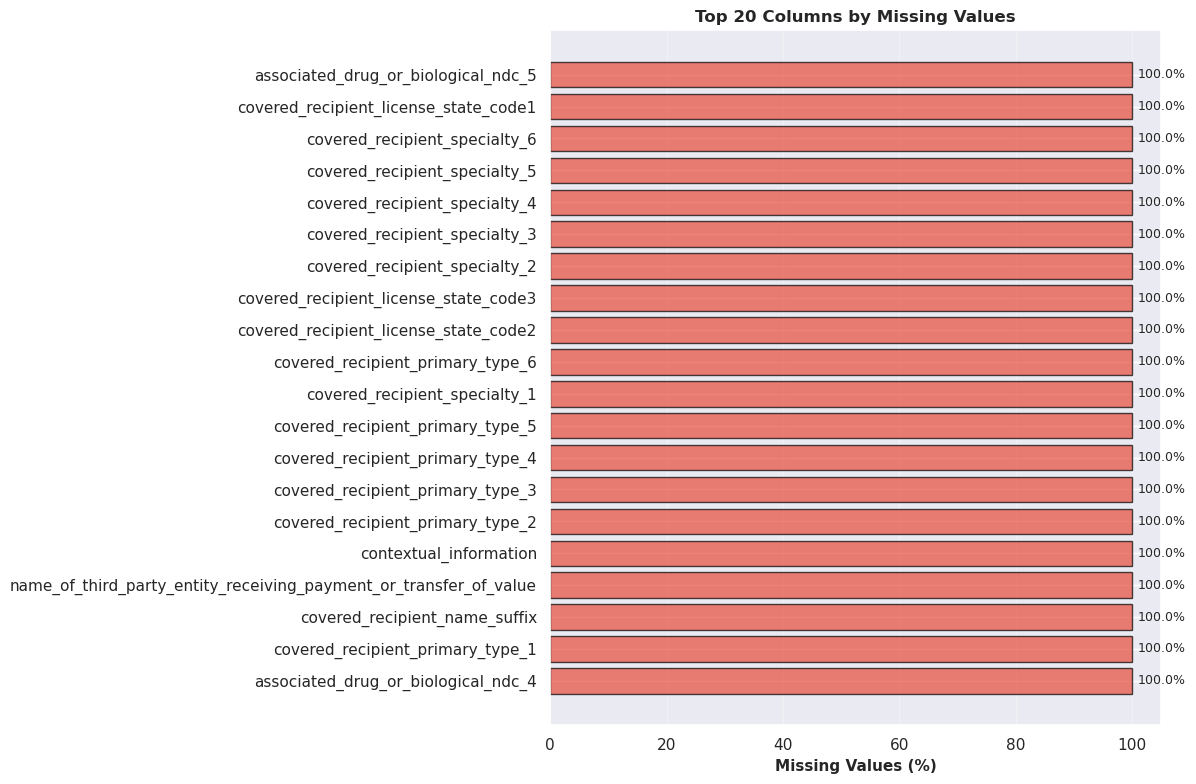

In [13]:
# Visualize missing values
if len(missing_stats) > 0:
    if use_visualizer:
        fig = visualizer.plot_missing_values(df, top_n=20)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")
else:
    print("No missing values detected")

In [14]:
# Data types summary
print("\nData Types Summary:")
print(df.dtypes.value_counts())

print("\n Sample of each data type:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns[:3]
    print(f"  {dtype}: {', '.join(cols)}")


Data Types Summary:
float64           59
string[python]    24
Int64              6
datetime64[ns]     2
Name: count, dtype: int64

 Sample of each data type:
  string: change_type, covered_recipient_type, teaching_hospital_name
  Int64: teaching_hospital_ccn, teaching_hospital_id, recipient_zip_code
  float64: covered_recipient_profile_id, covered_recipient_npi, covered_recipient_first_name
  datetime64[ns]: date_of_payment, payment_publication_date


## 4. Univariate Analysis

Analyzing individual variables to understand distributions, central tendencies, and variability.

In [15]:
# Payment amount analysis
if payment_col and payment_col in df.columns:
    print("=" * 70)
    print("PAYMENT AMOUNT STATISTICS")
    print("=" * 70)
    
    payment_stats = df[payment_col].describe()
    
    print(f"\nBasic Statistics:")
    print(f"  Count: {payment_stats['count']:,.0f}")
    print(f"  Mean: ${payment_stats['mean']:,.2f}")
    print(f"  Median: ${payment_stats['50%']:,.2f}")
    print(f"  Std Dev: ${payment_stats['std']:,.2f}")
    print(f"  Min: ${payment_stats['min']:,.2f}")
    print(f"  Max: ${payment_stats['max']:,.2f}")
    
    print(f"\nQuartiles:")
    print(f"  25th percentile: ${payment_stats['25%']:,.2f}")
    print(f"  50th percentile: ${payment_stats['50%']:,.2f}")
    print(f"  75th percentile: ${payment_stats['75%']:,.2f}")
    
    print(f"\nAdditional Percentiles:")
    for p in [90, 95, 99, 99.9]:
        val = df[payment_col].quantile(p/100)
        print(f"  {p}th percentile: ${val:,.2f}")
    
    # Skewness and Kurtosis
    skewness = df[payment_col].skew()
    kurtosis = df[payment_col].kurtosis()
    print(f"\nDistribution Shape:")
    print(f"  Skewness: {skewness:.2f}")
    print(f"  Kurtosis: {kurtosis:.2f}")
else:
    print(f"Warning: Payment column '{payment_col}' not found in dataframe")

PAYMENT AMOUNT STATISTICS

Basic Statistics:
  Count: 56,390
  Mean: $14,187,258.46
  Median: $19.79
  Std Dev: $1,191,016,886.83
  Min: $0.03
  Max: $100,000,776,811.00

Quartiles:
  25th percentile: $14.98
  50th percentile: $19.79
  75th percentile: $27.37

Additional Percentiles:
  90th percentile: $101.79
  95th percentile: $156.02
  99th percentile: $2,300.00
  99.9th percentile: $13,385.34

Distribution Shape:
  Skewness: 83.94
  Kurtosis: 7044.37


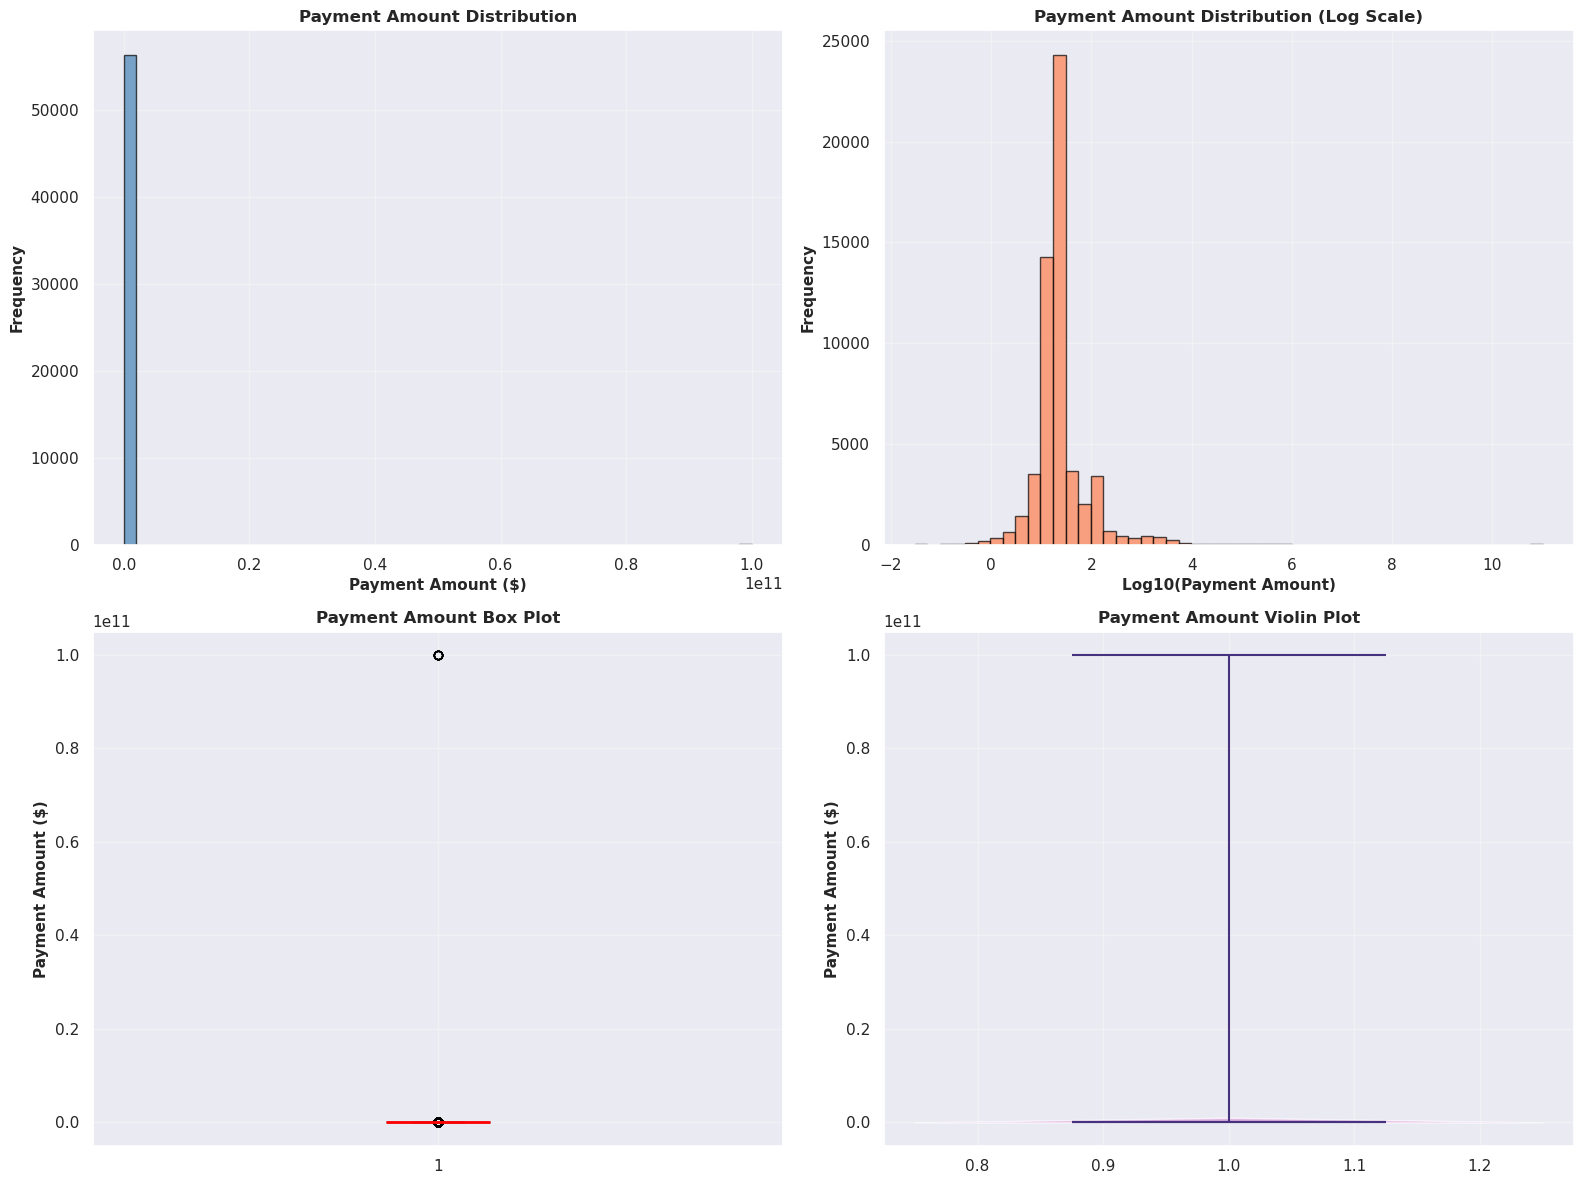

In [16]:
# Visualize payment distribution
if payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_payment_distribution_detailed(df, payment_col=payment_col)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

In [17]:
# Categorical variables analysis
print("=" * 70)
print("CATEGORICAL VARIABLES ANALYSIS")
print("=" * 70)

categorical_cols = [
    'Change_Type',
    'Covered_Recipient_Type',
    'Form_of_Payment_or_Transfer_of_Value',
    'Nature_of_Payment_or_Transfer_of_Value'
]

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        value_counts = df[col].value_counts().head(10)
        print(value_counts)
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Missing values: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.1f}%)")

CATEGORICAL VARIABLES ANALYSIS


In [18]:
# Visualize categorical distributions separately
categorical_cols_viz = [
    'Covered_Recipient_Type',
    'Form_of_Payment_or_Transfer_of_Value',
    'Nature_of_Payment_or_Transfer_of_Value'
]

for col in categorical_cols_viz:
    if col in df.columns and use_visualizer:
        print(f"\n{col} Distribution:")
        fig = visualizer.plot_category_distribution(df, col, top_n=15)
        if fig:
            plt.show()
    elif col not in df.columns:
        print(f"Column {col} not found in dataframe")

Column Covered_Recipient_Type not found in dataframe
Column Form_of_Payment_or_Transfer_of_Value not found in dataframe
Column Nature_of_Payment_or_Transfer_of_Value not found in dataframe


## 5. Bivariate & Multivariate Analysis

Explore relationships between multiple variables.

In [19]:
# Payment amount by recipient type
recipient_type_col = 'Covered_Recipient_Type'

if recipient_type_col in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("PAYMENT STATISTICS BY RECIPIENT TYPE")
    print("=" * 70)
    
    type_stats = df.groupby(recipient_type_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)
    
    type_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)', 'Std Dev ($)', 'Min ($)', 'Max ($)']
    type_stats = type_stats.sort_values('Total ($)', ascending=False)
    
    display(type_stats)

In [20]:
# Visualize payment by recipient type
if recipient_type_col and recipient_type_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        # Bivariate comparison plot
        fig = visualizer.plot_bivariate_comparison(df, group_col=recipient_type_col, 
                                                   amount_col=payment_col)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

In [21]:
# Payment by Nature of Payment
nature_col = 'Nature_of_Payment_or_Transfer_of_Value'

if nature_col in df.columns and payment_col in df.columns:
    print("\n" + "=" * 70)
    print("TOP 15 PAYMENT NATURES BY TOTAL AMOUNT")
    print("=" * 70)
    
    nature_stats = df.groupby(nature_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    nature_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    nature_stats = nature_stats.sort_values('Total ($)', ascending=False).head(15)
    
    display(nature_stats)
    
    # Visualize
    if use_visualizer:
        visualizer.plot_payment_nature_by_total(df, top_n=15)

## 6. Temporal Analysis

Analyze payment patterns over time.

In [22]:
# Correlation analysis for numeric features
if payment_col and payment_col in df.columns:
    numeric_features = [payment_col]
    
    # Add other numeric columns if available
    potential_numeric = ['Number_of_Payments_Included_in_Total_Amount', 
                        'Payment_Month', 'Payment_Quarter', 'Payment_DayOfWeek']
    
    for col in potential_numeric:
        if col in df.columns:
            numeric_features.append(col)
    
    if len(numeric_features) > 2 and use_visualizer:
        print(f"Analyzing correlations for {len(numeric_features)} numeric features")
        fig = visualizer.plot_correlation_heatmap(df, numeric_features)
        if fig:
            plt.show()
    else:
        print(f"Not enough numeric features for correlation analysis ({len(numeric_features)} found)")

Not enough numeric features for correlation analysis (1 found)


### Correlation Analysis

Explore correlations between numeric features.

In [23]:
# Monthly payment trends
if 'Payment_Month' in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("MONTHLY PAYMENT STATISTICS")
    print("=" * 70)
    
    monthly_stats = df.groupby('Payment_Month')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    monthly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    monthly_stats.index.name = 'Month'
    
    display(monthly_stats)

### Monthly Payment Statistics

In [24]:
# Comprehensive temporal trends visualization
if 'Date_of_Payment' in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_temporal_trends(df, date_col='Date_of_Payment', 
                                             amount_col=payment_col)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Temporal Trends Overview

Visualize overall temporal patterns in payments.

In [25]:
# Visualize monthly trends
if 'Payment_Month' in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_monthly_trends(df, payment_col=payment_col, month_col='Payment_Month')
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

In [26]:
# Quarterly analysis
if 'Payment_Quarter' in df.columns and payment_col and payment_col in df.columns:
    print("=" * 70)
    print("QUARTERLY PAYMENT STATISTICS")
    print("=" * 70)
    
    quarterly_stats = df.groupby('Payment_Quarter')[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    quarterly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    quarterly_stats.index.name = 'Quarter'
    
    display(quarterly_stats)
    
    # Visualize using comprehensive quarterly trends
    if use_visualizer:
        fig = visualizer.plot_quarterly_trends(df, quarter_col='Payment_Quarter', 
                                              amount_col=payment_col)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Quarterly Payment Statistics

## 7. Geographic Analysis {#geographic}

Analyzing payment distributions across geographic regions.

In [27]:
# State-level statistics
state_col = 'Recipient_State'

if state_col in df.columns and payment_col in df.columns:
    print("=" * 70)
    print("TOP 20 STATES BY PAYMENT METRICS")
    print("=" * 70)
    
    state_stats = df.groupby(state_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    
    state_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    state_stats = state_stats.sort_values('Total ($)', ascending=False).head(20)
    state_stats.index.name = 'State'
    
    display(state_stats)

### State-Level Payment Statistics

In [28]:
# Geographic distribution visualization
if state_col and state_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_geographic_distribution(df, state_col=state_col, 
                                                     amount_col=payment_col)
        if fig:
            plt.show()
    else:
        print("Visualizer not available - skipping plot")

### Geographic Distribution Overview

Comprehensive view of payment distribution across states.

In [29]:
# Visualize geographic distribution
if state_col and state_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.plot_state_comparison(df, state_col=state_col, 
                                               payment_col=payment_col, top_n=20)
        plt.show()
    else:
        print("Visualizer not available - skipping plot")

In [30]:
# Interactive choropleth map - Payment amounts by state
if state_col and state_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.create_choropleth_map(df, state_col=state_col, 
                                               amount_col=payment_col,
                                               title='Total Payment Amount by State')
        fig.show()
    else:
        print("Visualizer not available - skipping plot")

In [31]:
# Interactive scatter geo map - Payment distribution across US
if state_col and state_col in df.columns and payment_col and payment_col in df.columns:
    if use_visualizer:
        fig = visualizer.create_scatter_geo_map(df, state_col=state_col, 
                                               amount_col=payment_col,
                                               title='Payment Distribution Across US States')
        fig.show()
    else:
        print("Visualizer not available - skipping plot")

### Interactive Geographic Maps

In [32]:
# Create aggregated features by recipient
print("=" * 70)
print("FEATURE ENGINEERING: AGGREGATED RECIPIENT METRICS")
print("=" * 70)

# Identify recipient ID column
recipient_id_cols = [col for col in df.columns if 'recipient' in col.lower() and 'id' in col.lower()]
print(f"\nAvailable recipient ID columns: {recipient_id_cols}")

if len(recipient_id_cols) > 0:
    recipient_id_col = recipient_id_cols[0]  # Use first available ID column
    print(f"Using: {recipient_id_col}")
    
    # Create aggregated features
    agg_features = df.groupby(recipient_id_col).agg({
        payment_col: ['count', 'sum', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]
    agg_features = agg_features.reset_index()
    
    print(f"\nAggregated features created: {agg_features.shape}")
    display(agg_features.head(10))
else:
    print("WARNING: No recipient ID column found for aggregation")

FEATURE ENGINEERING: AGGREGATED RECIPIENT METRICS

Available recipient ID columns: ['covered_recipient_profile_id', 'covered_recipient_middle_name']
Using: covered_recipient_profile_id

Aggregated features created: (49498, 8)


,covered_recipient_profile_id,total_amount_of_payment_usdollars_count,total_amount_of_payment_usdollars_sum,total_amount_of_payment_usdollars_mean,total_amount_of_payment_usdollars_median,total_amount_of_payment_usdollars_std,total_amount_of_payment_usdollars_min,total_amount_of_payment_usdollars_max
0,20.00,1,15.57,15.57,15.57,NaN,15.57,15.57
1,21.00,1,19.36,19.36,19.36,NaN,19.36,19.36
2,22.00,0,0.00,NaN,NaN,NaN,NaN,NaN
3,40.00,0,0.00,NaN,NaN,NaN,NaN,NaN
4,138.00,1,13.59,13.59,13.59,NaN,13.59,13.59
5,160.00,5,500000758190.00,100000151638.00,100000151638.00,0.00,100000151638.00,100000151638.00
6,164.00,1,17.46,17.46,17.46,NaN,17.46,17.46
7,168.00,2,32.05,16.02,16.02,0.98,15.33,16.72
8,169.00,1,15.50,15.50,15.50,NaN,15.50,15.50
9,183.00,1,15.14,15.14,15.14,NaN,15.14,15.14


## 7.1 Data Partitioning 

Split the data according to project requirements 40/10/10/40

In [34]:
# data split (40/10/10/40)
print("Applying 40/10/10/40 data split...")

# fix random seed 
np.random.seed(42)

# create a random mask to assign each row to a category
perms = np.random.rand(len(df))

# map the random decimals to the four mandatory groups
df['dataset_usage'] = pd.cut(
    perms, 
    bins=[0, 0.4, 0.5, 0.6, 1.0], 
    labels=['train', 'test', 'validation', 'production']
)

# display the exact counts to confirm the split matches requirements
split_summary = df['dataset_usage'].value_counts().sort_index()
split_pct = df['dataset_usage'].value_counts(normalize=True).sort_index() * 100

print("\nFinal Partition Summary:")
for label in split_summary.index:
    print(f"  {label.capitalize()}: {split_summary[label]:,} rows ({split_pct[label]:.1f}%)")

Applying 40/10/10/40 data split...

Final Partition Summary:
  Train: 39,985 rows (40.0%)
  Test: 9,949 rows (9.9%)
  Validation: 10,061 rows (10.1%)
  Production: 40,005 rows (40.0%)


## 8. Feature Engineering

Create new features for predictive modeling.

### Baseline Engineering
Data leak prevention. This isolates the training set to establish what "normal" behavior looks for each doctor/hospital before merging them back into the main dataset. 

In [45]:
# drop existing features if they exist to prevent error
cols_to_drop = ['hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 
                'hist_pay_std', 'hist_pay_max', 'amt_to_avg_ratio', 'amt_to_max_ratio']

# only drop columns that are actually in the dataframe
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# setup column names
target_id = 'covered_recipient_profile_id' 
payment_col = 'total_amount_of_payment_usdollars'

# isolate training set to calculate historical "Normal" behavior
df_train = df[df['dataset_usage'] == 'train']
global_median = df_train[payment_col].median()

print(f"Calculating baselines for: {target_id}")

# calculate Recipient-Level historical metrics from training data
recipient_features = df_train.groupby(target_id).agg({
    payment_col: ['count', 'sum', 'mean', 'std', 'max']
}).reset_index()

# flatten columns so they are easy to reference
recipient_features.columns = [
    target_id, 'hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 'hist_pay_std', 'hist_pay_max'
]

# merge features back to the main dataframe
# using left merge to ensure we don't lose the production/validation rows
df = df.merge(recipient_features, on=target_id, how='left')

# create ratio features 
df['amt_to_avg_ratio'] = df[payment_col] / df['hist_pay_avg']
df['amt_to_max_ratio'] = df[payment_col] / df['hist_pay_max']

# Impute NaNs (handling recipients not seen in training)
df['is_new_recipient'] = df['hist_pay_avg'].isnull().astype(int)
df['hist_pay_avg'] = df['hist_pay_avg'].fillna(global_median)
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)

# final cleanup for remaining numerical NaNs
df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']] = \
    df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']].fillna(0)

Old feature columns cleared. Ready for fresh merge.
Calculating baselines for: covered_recipient_profile_id


### Statistical Deviation & Imputation

In [46]:
# temporal features, extracting seasonal patterns
df['date_of_payment'] = pd.to_datetime(df['date_of_payment'])
df['payment_month'] = df['date_of_payment'].dt.month
df['is_weekend'] = (df['date_of_payment'].dt.dayofweek >= 5).astype(int)

# categorical risk indicators
risk_categories = ['Gift', 'Entertainment', 'Travel and Lodging']
df['is_high_risk_nature'] = df['nature_of_payment_or_transfer_of_value'].isin(risk_categories).astype(int)

print("Block 2 Complete: Contextual features created.")

# final verification, view the engineered data across the 40/10/10/40 split
cols_to_view = ['dataset_usage', payment_col, 'hist_pay_avg', 'amt_to_avg_ratio', 'is_new_recipient', 'is_weekend']
display(df.groupby('dataset_usage')[cols_to_view].head(3))

Block 2 Complete: Contextual features created.


,dataset_usage,total_amount_of_payment_usdollars,hist_pay_avg,amt_to_avg_ratio,is_new_recipient,is_weekend
0,train,9.10,9.10,1.00,0,0
1,production,28.87,19.88,1.45,1,0
2,production,22.41,19.88,1.13,1,0
3,validation,25.47,19.88,1.28,1,0
4,train,23.36,21.62,1.08,0,0
5,train,26.68,26.68,1.00,0,0
7,production,106.83,149.57,0.71,0,0
17,validation,164.62,19.88,8.28,1,0
18,test,10.57,258.60,0.04,0,0
24,test,28.37,19.88,1.43,1,0


### Multi-Dimensional Anomaly Detection

In [47]:
# handle missing raw payment amounts by filling with the global training median
# this ensures that rows with NaN payments don't break the outlier detection models
df[payment_col] = df[payment_col].fillna(global_median)

# recalculate the ratio for these newly filled rows
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)

# check for any remaining NaNs across the entire feature set
final_nan_check = df[['hist_pay_avg', 'amt_to_avg_ratio', 'is_new_recipient', 'is_weekend']].isnull().sum()
print("Remaining NaN values per feature:")
print(final_nan_check)

Remaining NaN values per feature:
hist_pay_avg        0
amt_to_avg_ratio    0
is_new_recipient    0
is_weekend          0
dtype: int64


## 9. Outlier Detection

Identify and analyze outlier payments.

In [41]:
# Outlier detection using IQR method
if payment_col in df.columns:
    print("=" * 70)
    print("OUTLIER DETECTION ANALYSIS")
    print("=" * 70)
    
    amounts = df[payment_col].dropna()
    
    # Method 1: IQR (Interquartile Range)
    Q1 = amounts.quantile(0.25)
    Q3 = amounts.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = df[(df[payment_col] < lower_bound) | (df[payment_col] > upper_bound)]
    
    print(f"\nIQR Method:")
    print(f"  Q1 (25th percentile): ${Q1:,.2f}")
    print(f"  Q3 (75th percentile): ${Q3:,.2f}")
    print(f"  IQR: ${IQR:,.2f}")
    print(f"  Lower Bound: ${lower_bound:,.2f}")
    print(f"  Upper Bound: ${upper_bound:,.2f}")
    print(f"  Outliers Detected: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.2f}%)")
    
    # Method 2: Z-Score
    z_scores = np.abs(stats.zscore(amounts))
    z_threshold = 3
    z_outliers = df[np.abs(stats.zscore(df[payment_col].fillna(0))) > z_threshold]
    
    print(f"\nZ-Score Method (threshold={z_threshold}):")
    print(f"  Outliers Detected: {len(z_outliers):,} ({len(z_outliers)/len(df)*100:.2f}%)")
    
    # Method 3: Percentile-based
    percentile_99 = amounts.quantile(0.99)
    percentile_outliers = df[df[payment_col] > percentile_99]
    
    print(f"\nPercentile Method (99th percentile):")
    print(f"  Threshold: ${percentile_99:,.2f}")
    print(f"  Outliers Detected: {len(percentile_outliers):,} ({len(percentile_outliers)/len(df)*100:.2f}%)")

OUTLIER DETECTION ANALYSIS

IQR Method:
  Q1 (25th percentile): $18.63
  Q3 (75th percentile): $21.06
  IQR: $2.43
  Lower Bound: $14.98
  Upper Bound: $24.70
  Outliers Detected: 31,380 (31.38%)

Z-Score Method (threshold=3):
  Outliers Detected: 8 (0.01%)

Percentile Method (99th percentile):
  Threshold: $1,203.05
  Outliers Detected: 1,000 (1.00%)


### Outlier Detection Methods


OUTLIER CHARACTERISTICS

Payment Amount Statistics for Outliers:
  Count: 31,380
  Mean: $25,494,551.28
  Median: $25.75
  Min: $0.03
  Max: $100,000,776,811.00

Top 10 Outliers by Payment Amount:


,total_amount_of_payment_usdollars
75242,100000776811.00
24035,100000181746.00
1965,100000151638.00
36730,100000151638.00
36731,100000151638.00
36732,100000151638.00
36733,100000151638.00
24404,100000000329.00
98348,1619275.55
98341,772115.00


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.12/site-packages/pandas/core/indexes/base.py:3812 in get_loc              │
│                                                                                                  │
│   3809 │   │   """                                                                               │
│   3810 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3811 │   │   try:                                                                              │
│ ❱ 3812 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3813 │   │   except KeyError as err:                                                           │
│   3814 │   │   │   if isinstance(casted_key, slice) or (                                         │
│   3815 │   │   │   │   isinstance(casted_key, abc.Iterable)                                      │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:167                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:196                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7088                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7096                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'Total_Amount_of_Payment_USDollars_sum'

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:30                                                                                   │
│                                                                                                  │
│   27 │   │   }).reset_index()                                                                    │
│   28 │   │   df_aggregated.columns = ['Recipient_ID', 'Payment_Count', 'Total_Amount', 'Avg_A    │
│   29 │   │                                                                                       │
│ ❱ 30 │   │   fig = visualizer.plot_outliers_analysis(df_aggregated, amounts,                     │
│   31 │   │   │   │   │   │   │   │   │   │   │   │   lower_bound, upper_bound,                   │
│   32 │   │   │   │   │   │   │   │   │   │   │   │   z_threshold=3)                              │
│   33 │   │   if fig:                                                                             │
│                                                                                                  │
│ /home/sagemaker-user/project/aai540_3proj/utils/visualizations.py:328 in plot_outliers_analysis  │
│                                                                                                  │
│   325 │   │   axes[0, 1].set_yscale('log')                                                       │
│   326 │   │   axes[0, 1].grid(alpha=0.3)                                                         │
│   327 │   │                                                                                      │
│ ❱ 328 │   │   z_scores_all = stats.zscore(df_aggregated['Total_Amount_of_Payment_USDollars_sum   │
│   329 │   │   axes[1, 0].hist(z_scores_all, bins=50, color='coral', edgecolor='black', alpha=0   │
│   330 │   │   axes[1, 0].axvline(z_threshold, color='red', linestyle='--', linewidth=2,          │
│   331 │   │   │   │   │   │     label=f

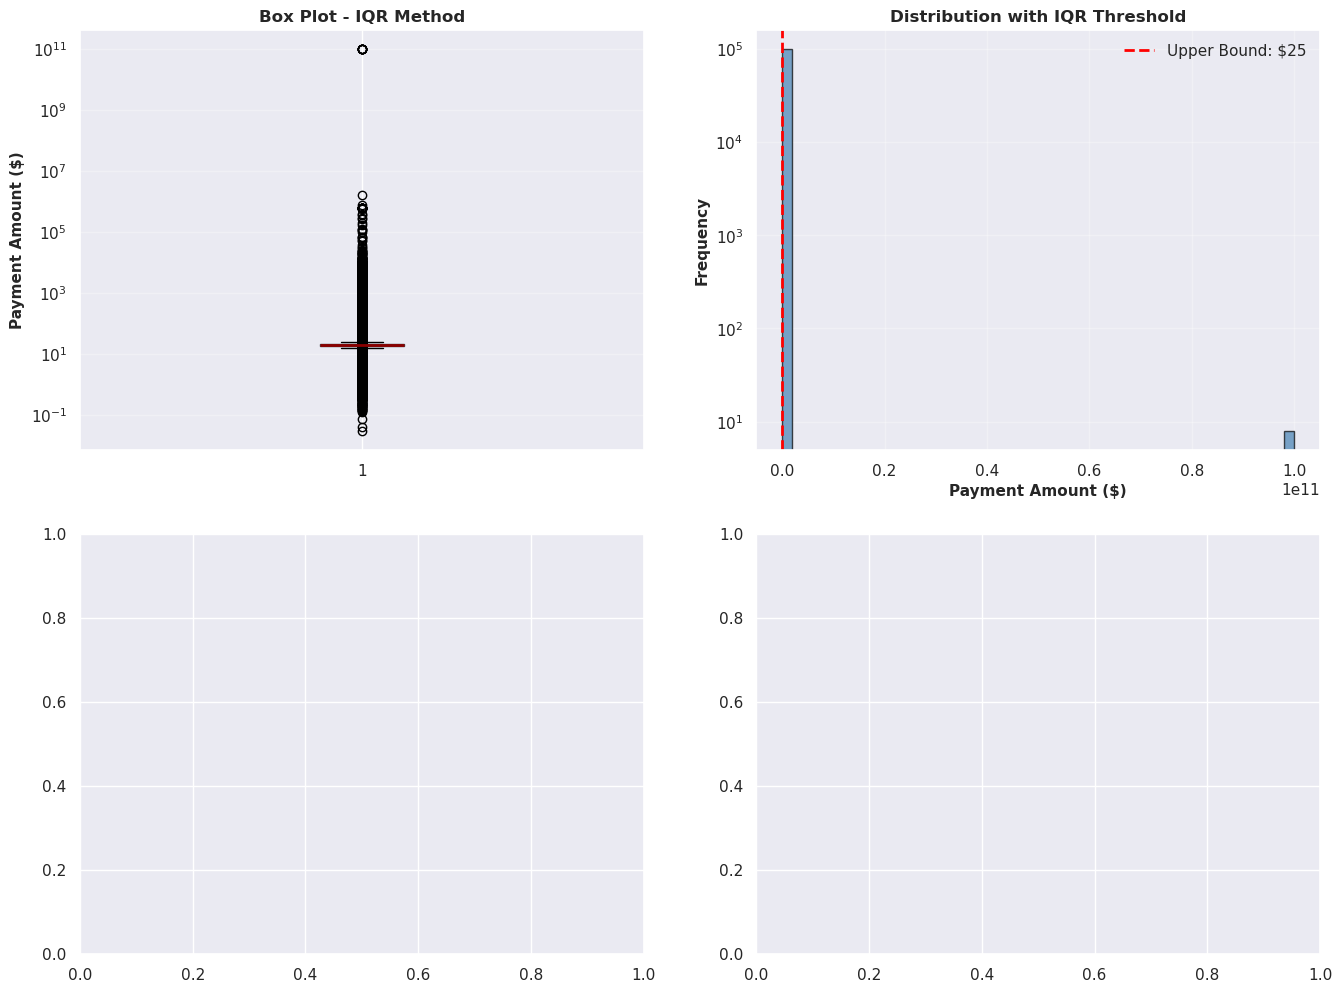

In [42]:
# Analyze outlier characteristics
if payment_col in df.columns and len(iqr_outliers) > 0:
    print("\n" + "=" * 70)
    print("OUTLIER CHARACTERISTICS")
    print("=" * 70)
    
    print(f"\nPayment Amount Statistics for Outliers:")
    print(f"  Count: {len(iqr_outliers):,}")
    print(f"  Mean: ${iqr_outliers[payment_col].mean():,.2f}")
    print(f"  Median: ${iqr_outliers[payment_col].median():,.2f}")
    print(f"  Min: ${iqr_outliers[payment_col].min():,.2f}")
    print(f"  Max: ${iqr_outliers[payment_col].max():,.2f}")
    
    # Top outliers
    print(f"\nTop 10 Outliers by Payment Amount:")
    top_outliers = iqr_outliers.nlargest(10, payment_col)[
        [col for col in [payment_col, recipient_type_col, state_col, nature_col] 
         if col in iqr_outliers.columns]
    ]
    display(top_outliers)
    
    # Visualize outliers
    if use_visualizer and len(recipient_id_cols) > 0:
        # Create aggregated data for outlier visualization
        df_aggregated = df.groupby(recipient_id_cols[0]).agg({
            payment_col: ['count', 'sum', 'mean']
        }).reset_index()
        df_aggregated.columns = ['Recipient_ID', 'Payment_Count', 'Total_Amount', 'Avg_Amount']
        
        fig = visualizer.plot_outliers_analysis(df_aggregated, amounts, 
                                                lower_bound, upper_bound, 
                                                z_threshold=3)
        if fig:
            plt.show()

## 10. Advanced Visualizations

Create sophisticated visualizations for deeper insights.

In [ ]:
# Interactive scatter plot - Payment amount vs Count
if payment_col and payment_col in df.columns and recipient_type_col and recipient_type_col in df.columns:
    if use_visualizer and len(recipient_id_cols) > 0:
        # Aggregate by recipient
        scatter_data = df.groupby([recipient_id_cols[0], recipient_type_col]).agg({
            payment_col: ['count', 'sum']
        }).reset_index()
        
        scatter_data.columns = ['Recipient_ID', 'Recipient_Type', 'Payment_Count', 'Total_Amount']
        
        # Use visualizer for interactive scatter
        fig = visualizer.create_interactive_scatter(
            scatter_data.head(1000),  # Limit for performance
            x_col='Payment_Count',
            y_col='Total_Amount',
            color_col='Recipient_Type',
            size_col='Total_Amount',
            hover_data=['Recipient_ID'],
            title='Payment Frequency vs Total Amount by Recipient Type'
        )
        fig.show()
    else:
        print("Visualizer or recipient ID not available - skipping plot")

### Interactive Payment Analysis

## 11. Key Findings & Summary

Generate comprehensive summary report.

In [ ]:
# Generate summary report
print("=" * 70)
print("KEY FINDINGS SUMMARY")
print("=" * 70)

print("\n1. DATASET OVERVIEW")
print(f"   - Total Records: {df.shape[0]:,}")
print(f"   - Total Columns: {df.shape[1]}")
print(f"   - Data Completeness: {(1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))*100:.1f}%")

if payment_col in df.columns:
    print("\n2. PAYMENT STATISTICS")
    print(f"   - Total Payment Amount: ${df[payment_col].sum():,.2f}")
    print(f"   - Average Payment: ${df[payment_col].mean():,.2f}")
    print(f"   - Median Payment: ${df[payment_col].median():,.2f}")
    print(f"   - Payment Range: ${df[payment_col].min():,.2f} - ${df[payment_col].max():,.2f}")

if recipient_type_col in df.columns:
    print("\n3. RECIPIENT DISTRIBUTION")
    type_counts = df[recipient_type_col].value_counts()
    for rtype, count in type_counts.items():
        pct = (count / len(df)) * 100
        print(f"   - {rtype}: {count:,} ({pct:.1f}%)")

if 'Payment_Month' in df.columns:
    print("\n4. TEMPORAL PATTERNS")
    month_with_most = df.groupby('Payment_Month')[payment_col].sum().idxmax()
    month_with_least = df.groupby('Payment_Month')[payment_col].sum().idxmin()
    print(f"   - Highest payment month: {month_with_most}")
    print(f"   - Lowest payment month: {month_with_least}")

if state_col in df.columns:
    print("\n5. GEOGRAPHIC DISTRIBUTION")
    print(f"   - Number of states: {df[state_col].nunique()}")
    top_state = df.groupby(state_col)[payment_col].sum().idxmax()
    top_state_amount = df.groupby(state_col)[payment_col].sum().max()
    print(f"   - Top state by total amount: {top_state} (${top_state_amount:,.2f})")

print("\n6. DATA QUALITY OBSERVATIONS")
high_missing = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(3)
print(f"   - Columns with highest missingness:")
for col, pct in high_missing.items():
    if pct > 0:
        print(f"     - {col}: {pct:.1f}%")

print("\n7. OUTLIER ANALYSIS")
if payment_col in df.columns:
    print(f"   - IQR outliers: {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.2f}%)")
    print(f"   - 99th percentile threshold: ${percentile_99:,.2f}")